# Tutorial POMDP robust planning

This is a tutorial for the paper "Bridging POMDPs and Bayesian decision making for robust maintenance planning under model uncertainty: An application to railway systems" (https://arxiv.org/abs/2212.07933), which shows 1) how to generate POMDP sequences given the ground truth model, 2) how to infer POMDP model parameter distributions given the available timeseries of observations and actions, and 3) how to incorporate all inferred distributions into the solutions for robust planning, including how to update all belief samples and how the robust action is exactly computed from the learned model.

In [1]:
%matplotlib inline

import pymc3 as pm
import numpy as np
import jax
import jax.numpy as jnp
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from scipy.stats import norm
from scipy.stats import multinomial
import theano.tensor as tt
import theano
from functools import partial

plt.rcParams['figure.constrained_layout.use'] = True

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## 1) POMDP data generation

We assume 3 hidden states and 2 possible actions. The first action ($a_0$) can be thought as the do-nothing action, while the other action ($a_1$) can be considered a repair action. 

We define the ground truth transition model, constituted by two transition matrices (one per action), and the ground truth initial probability distribution (flat over all states). Without loss of generality, this model concerns a system with some low probabilities of condition improvement under no-maintenance actions, just to show the inference results in this case.

For simplicity, we also define a probability distribution over actions in order to generate the POMDP sequences. Indeed, since these are only used to infer the POMDP parameter distributions, the actual policy that generated the trajectories is not relevant.

In [2]:
n_states = 3
n_actions = 2

p_init = np.array([1/3., 1/3., 1/3.])
p_actions = np.array([0.8, 0.2])
p_transition_0 = np.array(
    [[0.90, 0.09, 0.01],
     [0.01, 0.90, 0.09],
     [0.01, 0.05, 0.94]]
)
p_transition_1 = np.array(
    [[1.  , 0.  , 0.  ],
     [0.9 , 0.1 , 0.  ],
     [0.49, 0.5 , 0.01]]
)
p_transitions = np.array([p_transition_0, p_transition_1])
p_transitions

array([[[0.9 , 0.09, 0.01],
        [0.01, 0.9 , 0.09],
        [0.01, 0.05, 0.94]],

       [[1.  , 0.  , 0.  ],
        [0.9 , 0.1 , 0.  ],
        [0.49, 0.5 , 0.01]]])

In the transition matrices, entry $ij$ is defined as the probability to transition from state $i$ to state $j$, when the action associated with the transition matix is taken. 

The observation generating process is assumed to be a Gaussian model with the following ground truth parameters:

In [3]:
mus = [1, 0., -1]
sigmas = [1, 0.5, 0.2]

def gaussian_emissions(states: List[int], mus: List[float], sigmas: List[float]) -> List[float]:
    "True observation model (Gaussian)"
    emissions = []
    for state in states:
        e = norm.rvs(loc=mus[state], scale=sigmas[state])
        emissions.append(e)
    return emissions

In the following, 3 functions are defined to 1) generate an MDP sequence, 2) plot the POMDP sequences, and 3) generate multiple POMDP sequences. 

In [4]:
def mdp_sequence(p_init: np.array, p_actions:np.array, p_transitions: np.array, sequence_length: int) -> List[int]:
    """
    Generate a Markov Decision Process sequence based on p_init, p_actions and p_transitions.
    """
    initial_state = list(multinomial.rvs(1, p_init)).index(1)
    initial_action = list(multinomial.rvs(1, p_actions)).index(1)

    states = [initial_state]
    actions = [initial_action]
    for _ in range(sequence_length - 1):
        p_tr = p_transitions[actions[-1], states[-1]]
        new_state = list(multinomial.rvs(1, p_tr)).index(1)
        new_action = list(multinomial.rvs(1, p_actions)).index(1)
        states.append(new_state)
        actions.append(new_action)
    return states, actions

def plot_emissions(states, emissions, actions):
    """
    Plot POMDP sequences.
    """
    fig, axes = plt.subplots(figsize=(16, 12), nrows=3, ncols=1, sharex=True)
    axes[0].plot(states)
    axes[0].set_title("States")
    axes[0].set_yticks([0, 1, 2])
    axes[1].plot(emissions)
    axes[1].set_title("Emissions")
    axes[2].plot(actions)
    axes[2].set_title("Actions")
    axes[2].set_yticks([0, 1])
    sns.despine();

def generate_multiple_pomdp_seq(length_seq, number_seq, p_transitions, p_init, p_actions, mus, sigmas, plot=False): 
    """
    Generate multiple POMDP sequences.
    """
    #Generating a Markov Sequence
    states_all_seq = np.full((number_seq, length_seq), np.nan)
    actions_all_seq = np.full((number_seq, length_seq), np.nan)
    for i in range(number_seq):
        states, actions = mdp_sequence(p_init, p_actions, p_transitions, sequence_length=length_seq)
        states_all_seq[i, :] = states
        actions_all_seq[i, :] = actions
    states_all_seq = states_all_seq.astype(int)
    actions_all_seq = actions_all_seq.astype(int)
    # Generate Emissions: states and observables
    emissions_all_seq = np.full((number_seq, length_seq), np.nan)
    for i in range(number_seq):
        emissions = gaussian_emissions(states_all_seq[i, :], mus, sigmas)
        emissions_all_seq[i, :] = emissions
        if plot:
            plot_emissions(states_all_seq[i, :], emissions_all_seq[i, :], actions_all_seq[i, :])
    
    return states_all_seq, emissions_all_seq, actions_all_seq

We generate 10 sequences/timeseries of length 100.

In [5]:
length_seq = 100
number_seq = 10
states_all_seq, emissions_all_seq, actions_all_seq = generate_multiple_pomdp_seq(length_seq, number_seq, p_transitions, p_init, p_actions, mus, sigmas)

Let's plot the first one generated:

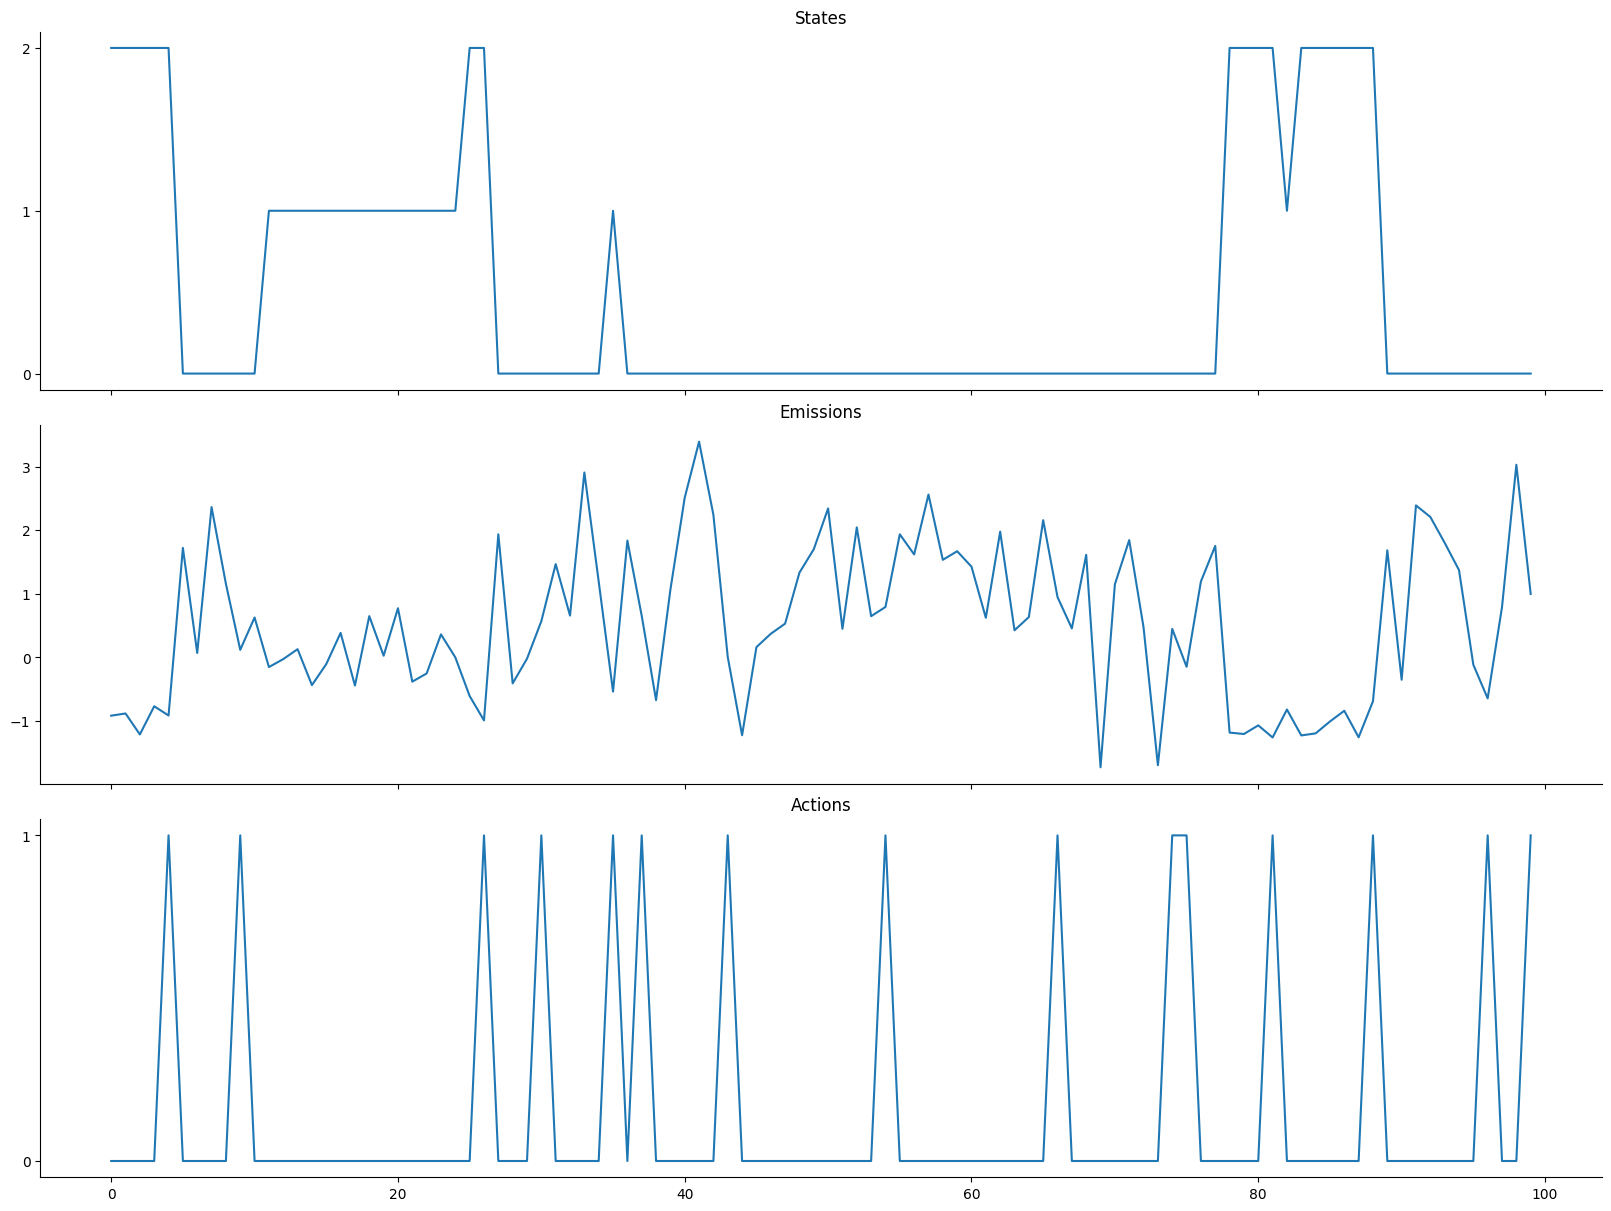

In [6]:
plot_emissions(states_all_seq[0, :], emissions_all_seq[0, :], actions_all_seq[0, :])

## 2) POMDP inference

The generated POMDP sequences are used to infer POMDP parameter distributions via MCMC sampling of a Hidden Markov Model (HMM) conditioned on actions.
The hidden states are modelled via Categorical distributions:

In [7]:
class HMMStates(pm.Categorical):
    def __init__(self, p_transition, init_prob, actions, n_states, *args, **kwargs):
        super(pm.Categorical, self).__init__(*args, **kwargs)
        self.p_transition = p_transition
        self.init_prob = init_prob
        self.actions = actions
        self.k = n_states
        self.mode = tt.cast(0,dtype='int64')

    def logp(self, x):
        p_init = self.init_prob
        acts = self.actions[:-1]
        p_tr = self.p_transition[acts, x[:-1]]

        # the logp of the initial state 
        initial_state_logp = pm.Categorical.dist(p_init).logp(x[0])

        # the logp of the rest of the states.
        x_i = x[1:]
        ou_like = pm.Categorical.dist(p_tr).logp(x_i)
        transition_logp = tt.sum(ou_like)
        return initial_state_logp + transition_logp

Then we define the likelihood model:

In [8]:
class GaussianEmissions(pm.Continuous):
    def __init__(self, states, mu, sigma, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.states = states
        self.sigma = sigma 
        self.mu = mu

    def logp(self, x):
        """
        x: observations
        """
        states = self.states
        mu = self.mu[states]
        sigma = self.sigma[states]

        like = tt.sum(pm.Normal.dist(mu=mu[1:], sigma=sigma[1:]).logp(x[1:])) 

        boundary_like = pm.Normal.dist(mu=mu[0], sigma=sigma[0]).logp(x[0])
        return like + boundary_like

And finally the entire HMM: 
- transition matrices and initial probability distribution are modelled via Dirichlet distributions. A completely flat prior is given to all parameters via the $\alpha$ hyperparameter in order to demonstrate that our inference methods are able to recover good estimates even when no prior knowledge is given. In general, it is better to assign more strongly regularizing priors to facilitate the inference.
- $\mu$ is given a Normal prior. We only assign decreasing values to the priors in order to keep the same order of the states during inference (i.e., state 0 produces on average greater valued emissions than state 1, etc...) for the purpose of the tutorial.
- $\sigma$ is given an Exponential prior, flat over all three dimensions again to demonstrate that accurate estimates will be inferred even in absence of prior knowledge. We again recommend use of regularizing informative priors in general. 

The parameters are sampled via the NUTS algorithm. We run 4 parallel chains with 2000 collected samples per chain, for a total of 8000 MCMC samples.

It should be noted that only the sequences of observations and actions are passed to the model for the parameter inference, while the ground truth hidden states are never accessed.

In [9]:
with pm.Model() as hmm:
    transition_mat = pm.Dirichlet(
        "p_transition",
        a=tt.ones((n_actions, n_states, n_states)), # hyperparmeter alpha
        shape=(n_actions, n_states, n_states))
    
    init_probs = pm.Dirichlet('init_probs', a = tt.ones((n_states,)), shape=n_states)
    
    # Prior for mu and sigma
    μ = pm.Normal("mu", mu=[0.5, 0., -0.5], sigma=1, shape=(n_states,)) 
    σ = pm.Exponential("sigma", lam=2, shape=(n_states,))
    
    for i in range(number_seq):
        # HMM state
        hmm_states_i = HMMStates(
            "hmm_states_" + str(i),
            p_transition=transition_mat,
            init_prob=init_probs,
            actions=actions_all_seq[i, :],
            n_states=n_states,
            shape=(length_seq,)
        )


        # Observed emission likelihood
        obs_i = GaussianEmissions(
            "emission_i" + str(i),
            states=hmm_states_i,
            mu=μ,
            sigma=σ,
            observed=np.array(emissions_all_seq[i, :]).astype("float")
        )
        
    nuts_step = pm.NUTS([hmm.sigma, hmm.mu, hmm.p_transition, hmm.init_probs], target_accept=0.9) 
    trace = pm.sample(2000, tune=3000, step=[nuts_step], chains=4, cores=4, progressbar=True)

/tmp/ipykernel_24640/1370613779.py:35: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(2000, tune=3000, step=[nuts_step], chains=4, cores=4, progressbar=True)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [init_probs, p_transition, mu, sigma]
>CategoricalGibbsMetropolis: [hmm_states_9, hmm_states_8, hmm_states_7, hmm_states_6, hmm_states_5, hmm_states_4, hmm_states_3, hmm_states_2, hmm_states_1, hmm_states_0]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 5711 seconds.
/home/garcieri/.local/lib/python3.8/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


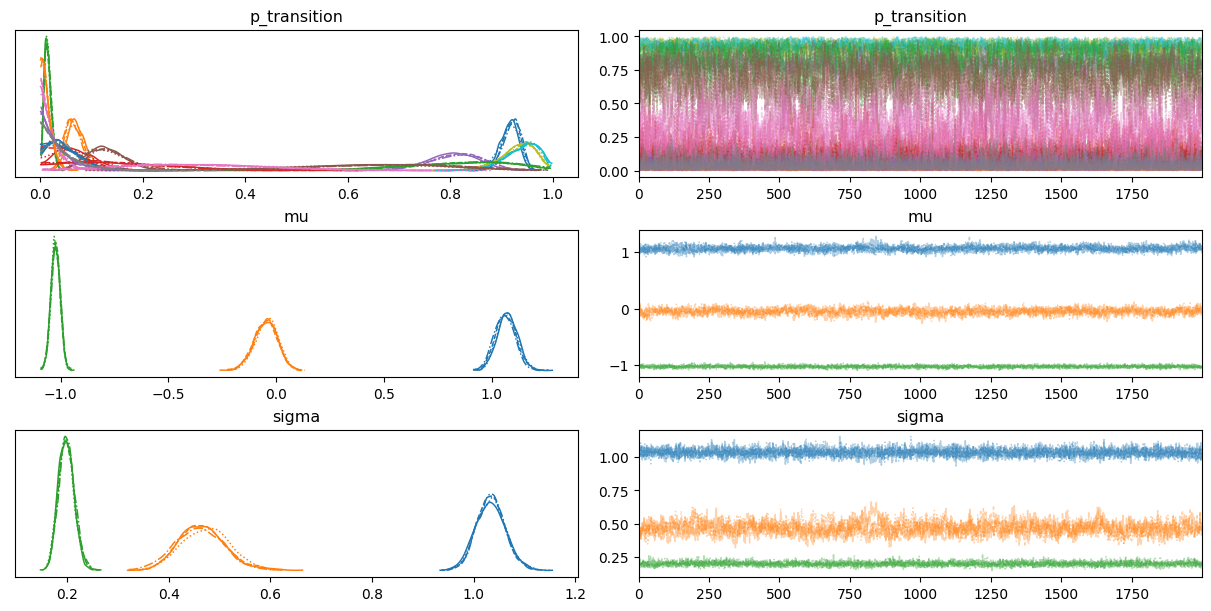

In [10]:
with hmm:
    az.plot_trace(trace,  var_names=["p_transition", "mu", "sigma"], );

Despite the flat prior we used for the transition matrices, even without differentiating between the deterioration and the repairing matrices, and the limited amount of data (only 10 timeseries), the MCMC inference of the HMM ran perfectly and was able to estimate parameter distributions close to the ground truth values. In general, we recommend to assign stronger regularizing priors that, for instance, assign higher probabilities on the diagonal and the right side of the deterioration matrix, and likewise higher probabilities on the left side of the repairing matrices, in order to facilitate the inference. 

In [11]:
# Ground truth transition matrices

p_transitions

array([[[0.9 , 0.09, 0.01],
        [0.01, 0.9 , 0.09],
        [0.01, 0.05, 0.94]],

       [[1.  , 0.  , 0.  ],
        [0.9 , 0.1 , 0.  ],
        [0.49, 0.5 , 0.01]]])

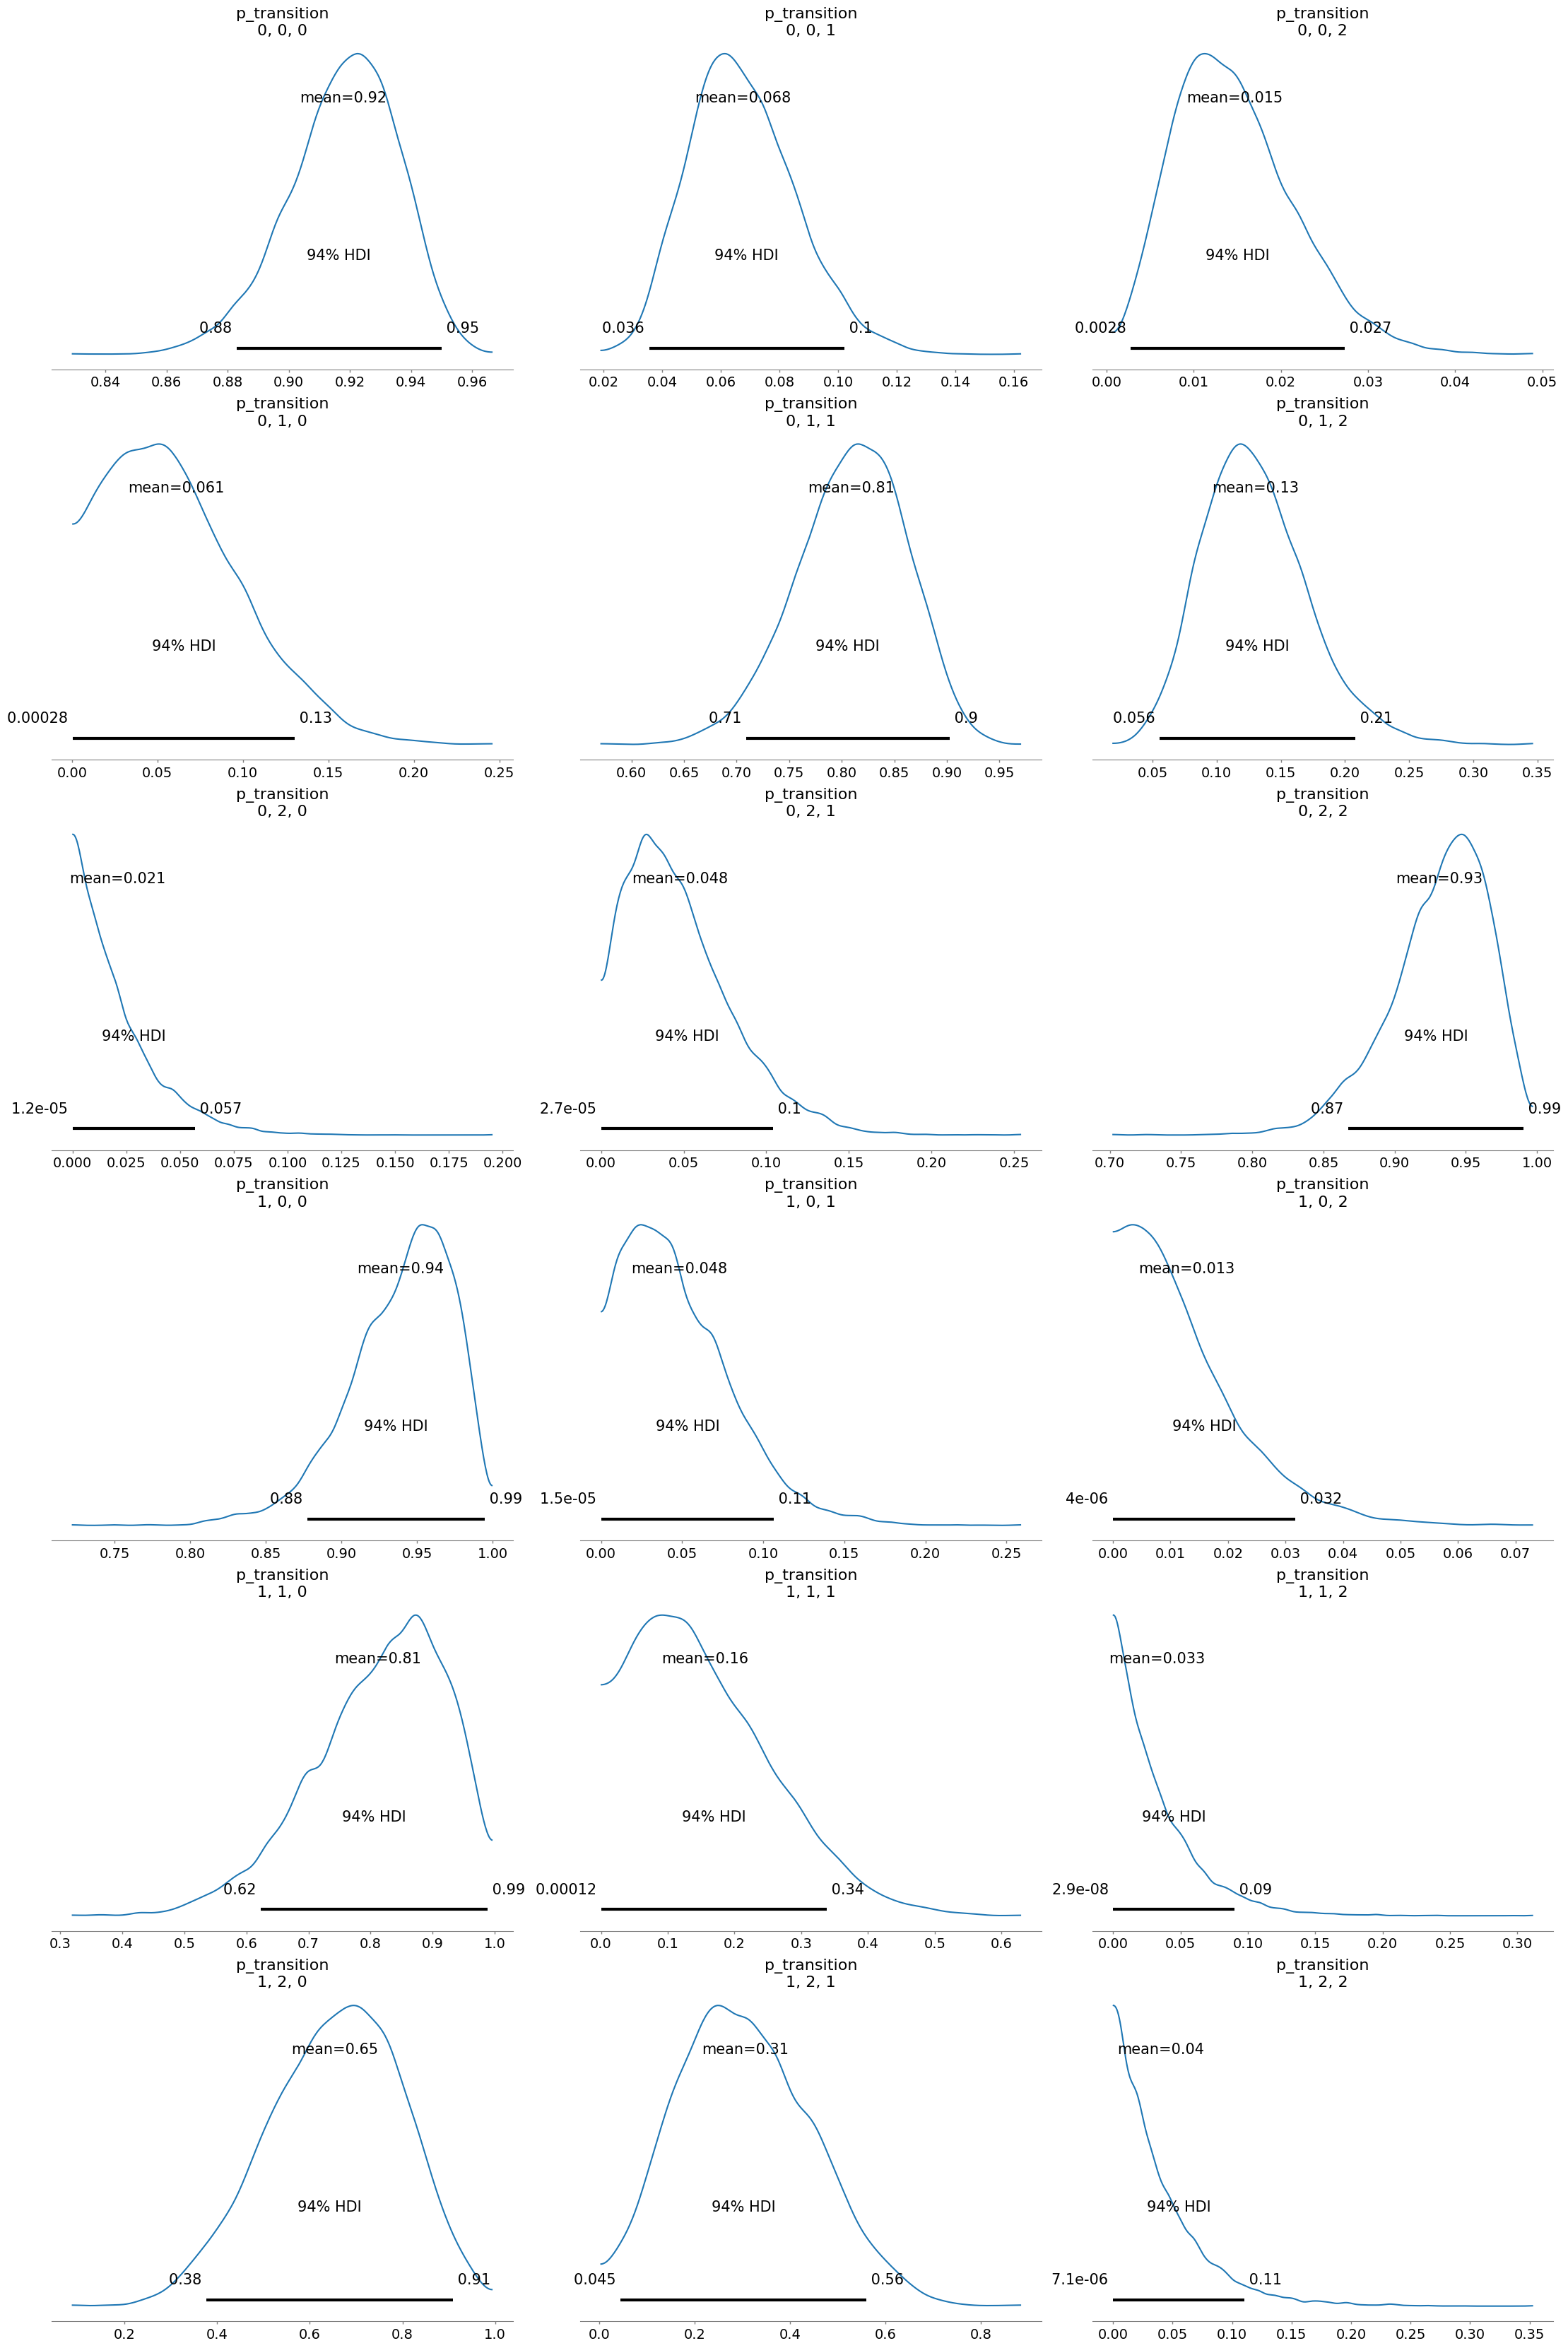

In [12]:
# Inferred matrices

with hmm:
    az.plot_posterior(trace,  var_names=["p_transition"]);

In [13]:
# Ground truth observation model parameters

mus, sigmas

([1, 0.0, -1], [1, 0.5, 0.2])

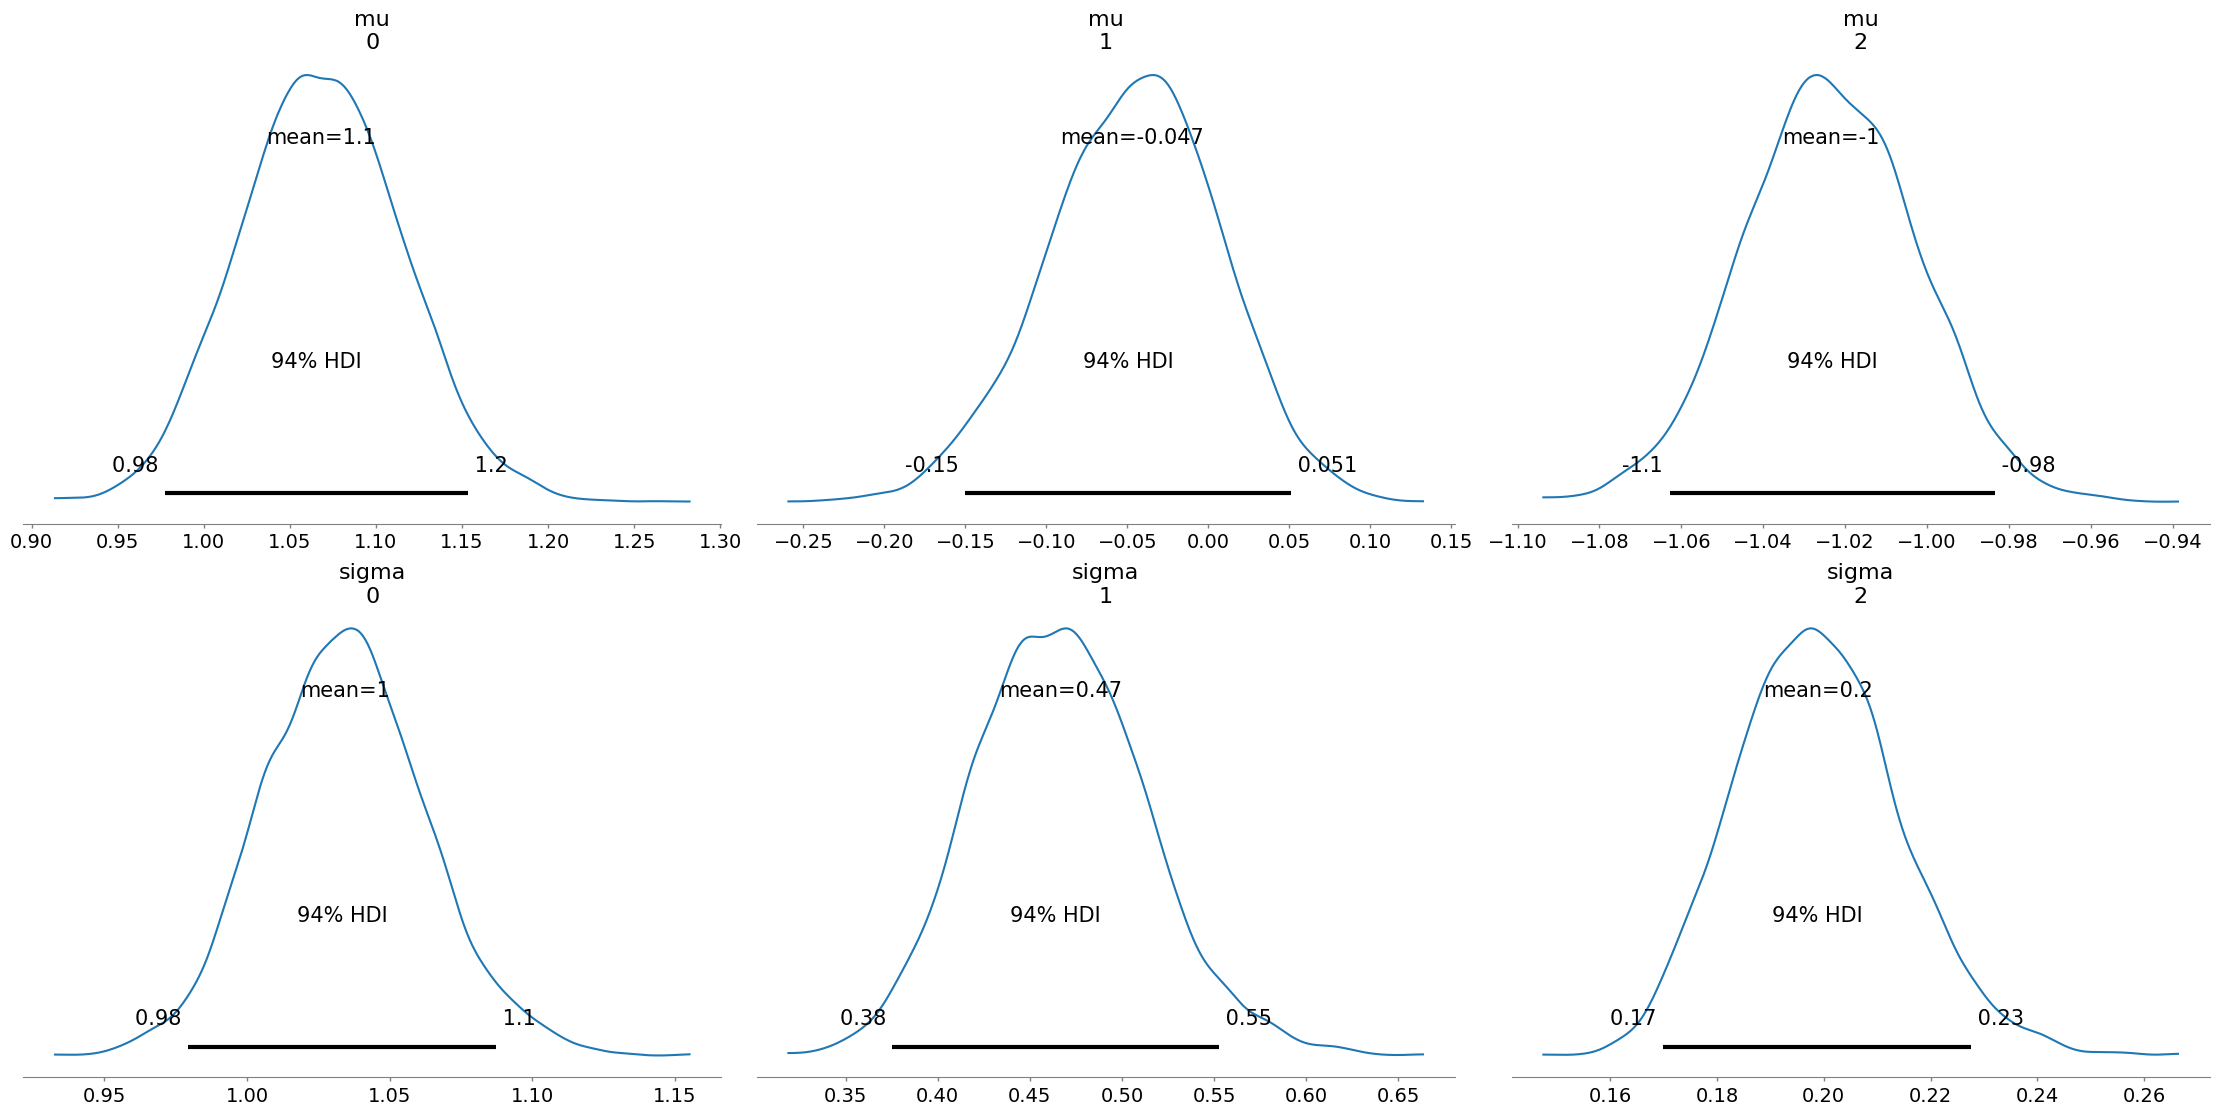

In [14]:
# Estimated observation model parameters

with hmm:
    az.plot_posterior(trace,  var_names=["mu", "sigma"]);

Let us save only the necessary inferred parameters:

In [15]:
inference_params = {
    'init_probs': jnp.asarray(trace['init_probs']),
    'p_transition': jnp.asarray(trace['p_transition']), 
    'mu': jnp.asarray(trace['mu']),
    'sigma': jnp.asarray(trace['sigma']), 
}

## 3) Robust POMDP planning

In the following we will show how to incorporate all inferred parameter distributions, approximated through the MCMC samples, into the solution, in order to compute the optimal action to be executed which is robust to model uncertainty. In addition, the computation of the action never accesses the ground truth parameters, as opposed to classical POMDP solutions, but only the learned parameter distributions. 

First, we define the action and the state space, the number of steps of the problem, the cost matrix, and our initial belief.

In [16]:
# Action space
A = {0: 'Do-nothing', 1: 'Repair'}

# State space
S = np.array([0, 1, 2])

# Steps of the problem
n_steps = 100

# Initialize belief with the initial probability distribution (approximated through the MCMC samples)
belief = inference_params['init_probs']

# Define costs
cost_a_0 = - 0
cost_a_1 = - 200 


cost_s_0 = - 10
cost_s_1 = - 100
cost_s_2 = - 800

# Define cost matrix where entry ij is the cost of taking action i at state j
cost_matrix = jnp.asarray([
    [cost_a_0 + cost_s_0, cost_a_0 + cost_s_1, cost_a_0 + cost_s_2],
    [cost_a_1 + cost_s_0, cost_a_1 + cost_s_1, cost_a_1 + cost_s_2],
])

print(f'Cost matrix: \n{cost_matrix}\n')


# Check belief is a distrbution (samples x hidden_states)
print(f'Belief shape: \n{belief.shape}\n \nCurrent mean belief (average through MCMC samples): \n{belief.mean(0).round(3)}') 

Cost matrix: 
[[  -10  -100  -800]
 [ -210  -300 -1000]]

Belief shape: 
(8000, 3)
 
Current mean belief (average through MCMC samples): 
[0.326      0.33800003 0.33600003]


As we will use the $Q_{MDP}$ planner, we need to compute the Q-values of the problem from the inferred transition model parameters. According to the paper, we compute distributions of Q-values. To speed up the computation we define our functions in jax to parallelize the computations over all samples. We assume a finite horizon problem and compute the Q-values with the popular value iteration backward algorithm.

In [17]:
def bellmanOperator(P, R, V, S, A):
        assert V.shape in ((S,), (1, S)), "V is not the right shape (Bellman operator)."
        assert P.shape == (A, S, S)
        assert R.shape == (A, S)
        # Looping through each action the Q-value matrix is calculated.
        Q = jnp.empty((A, S))
        for aa in range(A):
            q = R[aa] + P[aa].dot(V)
            Q = jax.ops.index_update(Q, jax.ops.index[aa], q)
        return (Q, Q.argmax(axis=0), Q.max(axis=0))
    
def Qvalues_finite_horizon(transitions, costs, N):
        V = jnp.zeros((n_states, N))
        Q = jnp.zeros((n_actions, n_states, N))
        policy = jnp.empty((n_states, N), dtype=int)
        # loop through each time period
        for n in range(N):
            q, W, X = bellmanOperator(transitions, costs, V[:, N - n], n_states, n_actions)
            stage = N - n - 1
            V = jax.ops.index_update(V, jax.ops.index[:, stage], X)
            Q = jax.ops.index_update(Q, jax.ops.index[:, :, stage], q)
            policy = jax.ops.index_update(policy, jax.ops.index[:, stage], W)
        return Q, V, policy
    
Q_values_fn = jax.vmap(partial(Qvalues_finite_horizon, costs=cost_matrix, N=n_steps))
q_values, V_vec, policy_vec = Q_values_fn(transitions=inference_params['p_transition'])

In [18]:
# Check that the computed q-values form a distribution
q_values.shape # (samples x actions x hidden_states x timesteps)

(8000, 2, 3, 100)

Let us initialize the problem (environment) with the ground truth parameters:

In [19]:
# Initialize the state
true_state = np.random.choice(S, p=p_init)

# Initialize the observation
true_obs = norm.rvs(loc=mus[true_state], scale=sigmas[true_state])

# Initialize timestep
t = 0

print(f'True state: {true_state}\nTrue Observation: {true_obs}')

True state: 1
True Observation: -0.21915603939862088


The first action is based on the initialized belief. The robust action is computed according to equation 17 in the paper:
$$
    a^*=\text{argmax}_{a\in A}\mathbf{E}_{\mathbf{\theta}\sim p(\mathbf{\theta}|\mathcal{D})}\left[\sum_{s\in S}b_{\mathbf{\theta}}(s)Q^{\pi^*}_{\mathbf{\theta}}(s, a)\right]
$$

In [20]:
# Select the q-values of the current timestep
current_q_values = q_values[:, :, :, t]

# Compute the robust optimal action
robust_action = jnp.multiply(current_q_values, belief.reshape(-1, 1, n_states)).sum(2).mean(0).argmax()

print(f'Robust action: \n{robust_action} ({A[int(robust_action)]})')

Robust action: 
1 (Repair)


Since the belief is initialized according to the learned initial probability distribution, which gives high probability also to deteriorated states (the true distribution assigns $\frac{1}{3}$ for any state), the robust optimal action is a repair action. This action is executed in the environment. 

In [21]:
# Compute next state with the true repair transition matrix
true_state = np.random.choice(S, p=p_transitions[robust_action, true_state])
                              
print(f'Next state: \n{true_state}\n')
  
# Compute next observation
true_obs = norm.rvs(loc=mus[true_state], scale=sigmas[true_state])       

print(f'Next observation: \n{true_obs}')

Next state: 
0

Next observation: 
0.3564316450918311


We can now update our belief distribution with the new observation and the executed action thanks to Bayes theorem and the inferred model parameters. In order to update all belief samples, we again define our functions in jax to parallelize over all samples.

In [23]:
def transition_model_probability(next_state, state, action):
    "Return transition probabilities (all MCMC samples)"
    return inference_params['p_transition'][:, action, state, next_state]
    
def observation_model_probability(observation, next_state):
    "Compute observation likelihood for all samples"
    # Select mu and sigma from the inferred distributions for every possible next state
    # Both mu and sigma are paremeter distributions of shape (samples x hidden_states)
    inference_mu = inference_params['mu'][:, next_state]
    inference_sigma = inference_params['sigma'][:, next_state]
    
    # Compute the observation likelihood
    prob = norm.pdf(observation, loc=np.asarray(inference_mu), scale=np.asarray(inference_sigma))
    return prob
    
def update_belief(observation, action, belief):
    """
    Update all belief samples with the new obs and action. The computation is vectorized over all samples.
    """
    new_belief = jnp.zeros(belief.shape)
    total_prob = 0 # Normalizing factor
    action = jnp.asarray(action)
    observation = jnp.asarray(observation)
    
    for next_state in jnp.asarray(S):
        # Compute observation likelihood
        observation_prob = observation_model_probability(observation, next_state)
        
        # Compute transition probabilities
        trans_model_prob = jax.vmap(partial(transition_model_probability, next_state=next_state, action=action))
        # Computation parallelized over all states in S
        transition_prob = jnp.sum(trans_model_prob(state=jnp.asarray(S)).reshape(-1, n_states) * belief, 1)
        
        # Compute unnormalized posterior probabilities (numerator in Bayes theorem)
        prob = observation_prob * transition_prob
        new_belief = jax.ops.index_update(new_belief, jax.ops.index[:, next_state], prob)
        
        # Update normalizing factor
        total_prob += prob
        
    # Belief normalization
    new_belief /= total_prob.reshape(-1,1)
    return new_belief

In [24]:
belief = update_belief(true_obs, robust_action, belief)

print(f'New belief shape: \n{belief.shape}\n \nNew mean belief (average through MCMC samples): \n{belief.mean(0).round(3)}')

New belief shape: 
(8000, 3)
 
New mean belief (average through MCMC samples): 
[0.731      0.26900002 0.        ]


Based on the updated belief, we can compute the new robust optimal action for new timestep of the problem:

In [25]:
# Update timestep
t += 1

# Compute new robust action
current_q_values = q_values[:, :, :, t]
robust_action = jnp.multiply(current_q_values, belief.reshape(-1, 1, n_states)).sum(2).mean(0).argmax()

print(f'New robust action: \n{robust_action} ({A[int(robust_action)]})')

New robust action: 
0 (Do-nothing)


And a new timestep of the sequential decision making problem initiates. 

In summary, we have shown how to learn the POMDP model parameters and how to plan a robust optimal action, which is optimized over all inferred model parameter distributions and, opposed to classical POMDP solution algorithms, never accesses the ground truth model for the computation.